# Evaluating Alignment of Text-to-image Diffusion Models

---

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow/supervision/blob/develop/docs/notebooks/evaluating-alignment-of-text-to-image-diffusion-models.ipynb)

Click the `Open in Colab` button to run the cookbook on Google Colab.

## Introduction

It is a common scenario to evaluate text-to-image models for its alignment to the prompt. One way to test it is to use a set of prompts, consisting of number of objects and their basic physical properties (e.g. color), to generate images and manually evaluate the results. This process can be greatly improved using object detection models.

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Thu Feb 15 12:41:37 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P0              28W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Install required packages¶

In this cookbook, we'll leverage the following Python packages:
* `diffusers` for image generation pipelines,
* `ultralytics` for running object detection,
* and `supervision` for visualizing detections.

In [2]:
!pip install -q torch diffusers accelerate ultralytics dill git+https://github.com/openai/CLIP.git supervision==0.18.0

  Preparing metadata (setup.py) ... done


## Imports

In [3]:
import itertools

import cv2
from diffusers import StableDiffusionXLPipeline
import numpy as np
from PIL import Image
import supervision as sv
import torch
from ultralytics import YOLO


## Generating an image

We'll use [SDXL](https://huggingface.co/docs/diffusers/using-diffusers/sdxl) model to generate our image. Let's initialize our pipeline first:

In [4]:
pipeline = StableDiffusionXLPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    torch_dtype=torch.float16,
    variant="fp16",
    use_safetensors=True,
).to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In this example, we'll focus on generating an image of a black cat playing with a blue ball next to a parked white car. We don't care about the aesthetic aspect of the image.

  0%|          | 0/50 [00:00<?, ?it/s]

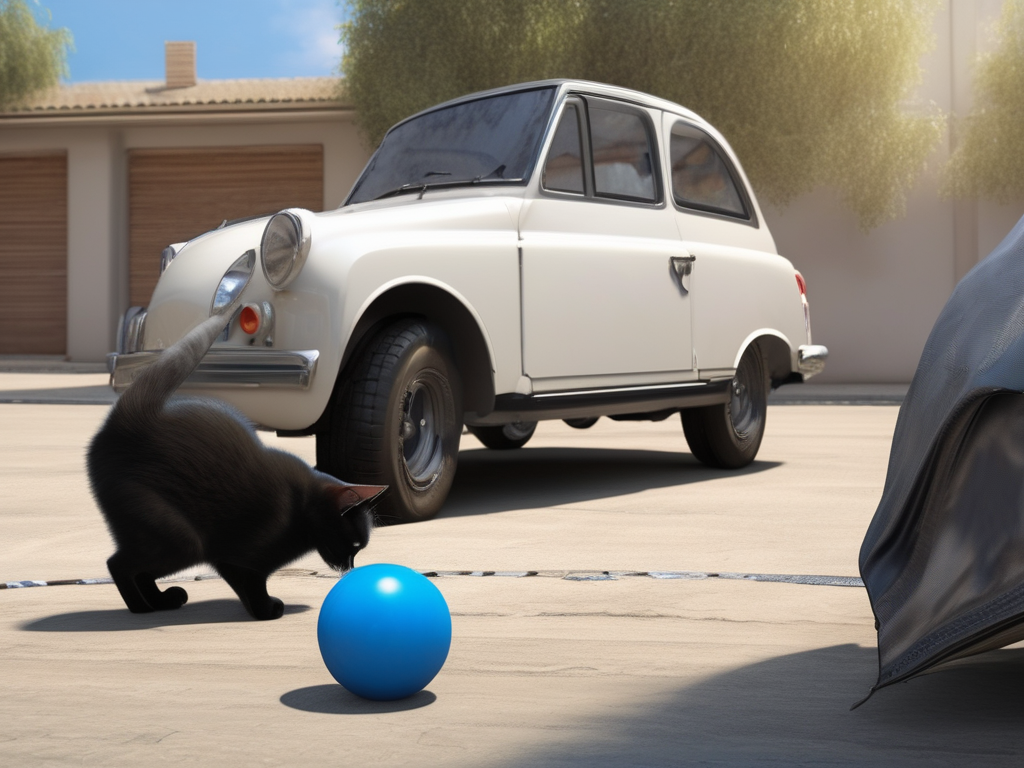

In [5]:
image = pipeline(
    prompt="a black cat playing with a blue ball next to a parked white car, wide angle, photorealistic",
    negative_prompt="low quality, blurred, text, illustration",
    generator=torch.manual_seed(9213799),
    num_inference_steps=50,
    width=1024,
    height=768,
).images[0]
image

Not bad! The results seem to be well-aligned with the prompt.

## Detecting objects

Now, let's see how can we detect the objects automatically. For this, we'll use [YOLO-World](https://docs.ultralytics.com/models/yolo-world/) model from `ultralytics` library.

In [6]:
model = YOLO("yolov8m-world.pt")

YOLO-World model allows us to [define our own set of labels](https://docs.ultralytics.com/models/yolo-world/#set-prompts). Let's create it by combining lists of pre-defined colors and objects.

In [7]:
colors = ["green", "yellow", "black", "blue", "red", "white", "orange"]
objects = ["car", "cat", "ball", "dog", "tree", "house", "person"]
pairs = [f"{color} {obj}" for color, obj in itertools.product(colors, objects)]
print("Number of labels:", len(pairs))

Number of labels: 49


Let's feed these labels into our model:

In [8]:
model.set_classes(pairs)

Time to detect some objects!

In [9]:
results = model(image, verbose=False)[0]

We'll convert the results to the [sv.Detections](https://supervision.roboflow.com/latest/detection/core/#supervision.detection.core.Detections) format to enable features like filtering or annotations.

In [10]:
detections = sv.Detections.from_ultralytics(results)

Speaking of which: we only care about strong detections, so we filter out ones that are below 0.5 confidence.

In [11]:
valid_detections = detections[detections.confidence >= 0.5]

A quick peek on the detected labels and their score:

In [12]:
labels = [
    f"{results.names[class_id]} {confidence:0.2f}"
    for class_id, confidence
    in zip(valid_detections.class_id, valid_detections.confidence)
]
labels

['blue ball 0.91', 'black cat 0.70', 'white car 0.64']

## Visualizing results

Now, let's use the power of `supervision` to visualize them. Our output image is in [Pillow](https://pillow.readthedocs.io/en/stable/index.html) format, but annotators expect the image to be a BGR `np.ndarray`. Here's a simple helper function that's going to help us with the conversion:

In [13]:
def pil_to_bgr_array(image: Image.Image) -> np.array:
  rgb_array = np.array(image)
  bgr_array = cv2.cvtColor(rgb_array, cv2.COLOR_RGB2BGR)
  return bgr_array

Time to define how we want our detections to be visualized. A combination of [sv.BoundingBoxAnnotator](https://supervision.roboflow.com/latest/annotators/#supervision.annotators.core.BoundingBoxAnnotator) and [sv.LabelAnnotator](https://supervision.roboflow.com/latest/annotators/#supervision.annotators.core.LabelAnnotator) should be perfect.

In [14]:
bounding_box_annotator = sv.BoundingBoxAnnotator(thickness=2)
label_annotator = sv.LabelAnnotator(text_thickness=1, text_scale=0.5)

Finally, annotating our image is as simple as calling `annotate` methods from our annotators:

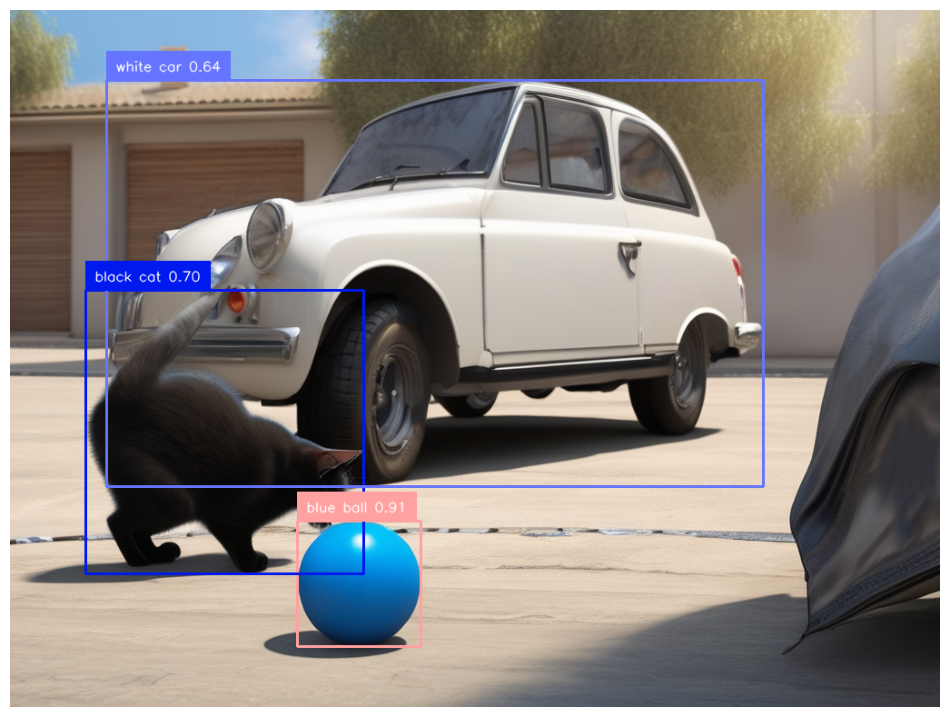

In [15]:
annotated_image = pil_to_bgr_array(image)
annotated_image = bounding_box_annotator.annotate(annotated_image, valid_detections)
annotated_image = label_annotator.annotate(annotated_image, valid_detections, labels)
sv.plot_image(annotated_image, (12, 12))

## Testing it automatically

We can also test if all requested objects are in the generated image by comparing a set of ground-truth labels with predicted ones:

In [16]:
gt = {"black cat", "blue ball", "white car"}
pred = {results.names[class_id] for class_id in valid_detections.class_id}

pred.issubset(gt)

True

Using [sv.Detections](https://supervision.roboflow.com/latest/detection/core/#supervision.detection.core.Detections) makes it super easy to do.

## Next steps

In this tutorial you learned how to detect and visualize objects for a simple image generation evaluation study.

Having a pipeline capable of evaluating a single image, the natural next step should be to run it on a set of pre-defined scenarios and calculate metrics.